Loading datasets...
Preparing training features...
Extracting features from graphs...
Processing graph 1/1050
Processing graph 101/1050
Processing graph 201/1050
Processing graph 301/1050
Processing graph 401/1050
Processing graph 501/1050
Processing graph 601/1050
Processing graph 701/1050
Processing graph 801/1050
Processing graph 901/1050
Processing graph 1001/1050
Training and evaluating models...
RandomForest CV Accuracy: 0.3333 (+/- 0.0000)
GradientBoosting CV Accuracy: 0.3333 (+/- 0.0000)
Training best model: RandomForest
Evaluating on validation set...
Extracting features from graphs...
Processing graph 1/150
Processing graph 101/150
Validation Accuracy: 0.3333

Classification Report:
              precision    recall  f1-score   support

        Tree       0.00      0.00      0.00        50
      Cyclic       0.00      0.00      0.00        50
         DAG       0.33      1.00      0.50        50

    accuracy                           0.33       150
   macro avg       0.11   

In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.3 MB/s eta 0:00:00


Using device: cpu
Converting data to PyTorch Geometric format...
Analyzing dataset to determine label mapping...
Determined label mapping:
  2: TREE
  1: DAG
  0: CYCLIC
Processing graph 1/1050
Processing graph 1001/1050
Successfully processed 1050 graphs, failed: 0
Converting data to PyTorch Geometric format...
Processing graph 1/150
Successfully processed 150 graphs, failed: 0
Starting training for 100 epochs...
Epoch 000: Train Loss: 1.0465, Val Loss: 1.0949, Val Acc: 0.3333
Epoch 010: Train Loss: 0.0618, Val Loss: 0.1222, Val Acc: 0.9800
Epoch 020: Train Loss: 0.0806, Val Loss: 0.0833, Val Acc: 0.9800
Epoch 030: Train Loss: 0.0271, Val Loss: 1.7061, Val Acc: 0.6667
Epoch 040: Train Loss: 0.0241, Val Loss: 0.3504, Val Acc: 0.7667
Epoch 050: Train Loss: 0.0226, Val Loss: 0.0591, Val Acc: 1.0000
Epoch 060: Train Loss: 0.0219, Val Loss: 1.1204, Val Acc: 0.7000
Epoch 070: Train Loss: 0.0222, Val Loss: 0.5706, Val Acc: 0.7933
Epoch 080: Train Loss: 0.0214, Val Loss: 0.3976, Val Acc: 0.80

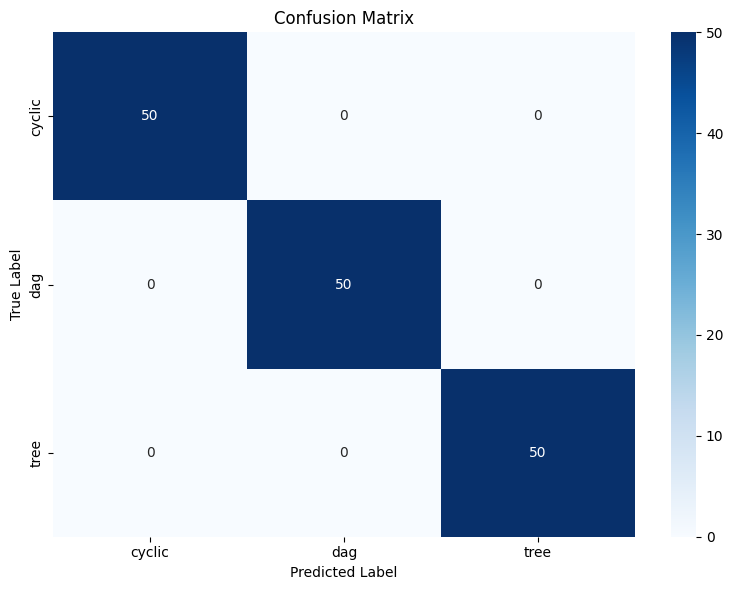

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GraphConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx
import pandas as pd
import numpy as np
import networkx as nx
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class GraphDataProcessor:
    """Process graph data and determine correct label mappings"""

    def __init__(self):
        self.label_mapping = None
        self.reverse_mapping = None

    def parse_edgelist(self, edgelist_str):
        """Parse string representation of edgelist into actual edges"""
        try:
            if isinstance(edgelist_str, str):
                # Handle different string formats
                edgelist_str = edgelist_str.strip()
                if edgelist_str.startswith('[') and edgelist_str.endswith(']'):
                    # Try to evaluate as Python list
                    try:
                        edges = ast.literal_eval(edgelist_str)
                        return [(int(u), int(v)) for u, v in edges]
                    except:
                        pass

                # Parse manually if eval fails
                edges_str = edgelist_str.strip('[]').replace('(', '').replace(')', '')
                edges = []
                pairs = edges_str.split('), ')
                for pair in pairs:
                    if pair.strip():
                        nodes = pair.replace(',', '').split()
                        if len(nodes) >= 2:
                            edges.append((int(nodes[0]), int(nodes[1])))
                return edges
            return []
        except Exception as e:
            print(f"Error parsing edgelist: {e}")
            return []

    def analyze_graph_properties(self, edges):
        """Analyze graph to determine its true type"""
        if not edges:
            return "empty"

        # Create NetworkX graph
        G = nx.DiGraph()
        G.add_edges_from(edges)

        # Get undirected version for tree checking
        G_undirected = G.to_undirected()

        # Check properties
        is_dag = nx.is_directed_acyclic_graph(G)
        is_tree = nx.is_tree(G_undirected)
        has_cycles = not is_dag

        # Determine type
        if is_tree:
            return "tree"
        elif has_cycles:
            return "cyclic"
        elif is_dag:
            return "dag"
        else:
            return "unknown"

    def determine_label_mapping(self, df):
        """Determine correct mapping between numeric labels and graph types"""
        print("Analyzing dataset to determine label mapping...")

        # Sample analysis - analyze first 100 graphs
        sample_size = min(100, len(df))
        sample_df = df.sample(n=sample_size, random_state=42)

        label_to_types = {0: [], 1: [], 2: []}

        for _, row in sample_df.iterrows():
            edges = self.parse_edgelist(row['edgelist'])
            graph_type = self.analyze_graph_properties(edges)
            label = int(row['label'])
            label_to_types[label].append(graph_type)

        # Determine most common type for each label
        mapping = {}
        for label, types in label_to_types.items():
            if types:
                most_common_type = Counter(types).most_common(1)[0][0]
                mapping[label] = most_common_type

        # Create clean mapping
        type_to_label = {}
        for label, graph_type in mapping.items():
            type_to_label[graph_type] = label

        # Ensure we have all three types
        expected_types = ['tree', 'cyclic', 'dag']
        for expected_type in expected_types:
            if expected_type not in type_to_label:
                # Find unused label
                used_labels = set(type_to_label.values())
                for label in [0, 1, 2]:
                    if label not in used_labels:
                        type_to_label[expected_type] = label
                        break

        self.label_mapping = {v: k for k, v in type_to_label.items()}
        self.reverse_mapping = type_to_label

        print("Determined label mapping:")
        for label, graph_type in self.label_mapping.items():
            print(f"  {label}: {graph_type.upper()}")

        return self.label_mapping

    def create_pytorch_geometric_data(self, edges, label):
        """Convert edge list to PyTorch Geometric Data object"""
        if not edges:
            # Handle empty graph
            x = torch.tensor([[1.0]], dtype=torch.float)
            edge_index = torch.tensor([[], []], dtype=torch.long)
            return Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))

        # Get all unique nodes
        nodes = set()
        for u, v in edges:
            nodes.add(u)
            nodes.add(v)

        # Create node mapping to ensure continuous indices
        node_mapping = {node: idx for idx, node in enumerate(sorted(nodes))}

        # Convert edges using node mapping
        edge_list = []
        for u, v in edges:
            edge_list.append([node_mapping[u], node_mapping[v]])

        # Create edge index tensor
        if edge_list:
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        else:
            edge_index = torch.tensor([[], []], dtype=torch.long)

        # Create node features (we'll use simple features for now)
        num_nodes = len(nodes)

        # Create richer node features
        G = nx.DiGraph()
        G.add_edges_from(edges)

        node_features = []
        for original_node in sorted(nodes):
            features = []

            # Basic degree features
            in_degree = G.in_degree(original_node)
            out_degree = G.out_degree(original_node)
            total_degree = in_degree + out_degree

            features.extend([in_degree, out_degree, total_degree])

            # Structural features
            features.append(1.0 if in_degree == 0 else 0.0)  # is_source
            features.append(1.0 if out_degree == 0 else 0.0)  # is_sink

            # Position-based features (simplified)
            features.append(float(original_node))  # node_id as feature

            node_features.append(features)

        x = torch.tensor(node_features, dtype=torch.float)

        return Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))

class GraphNeuralNetwork(torch.nn.Module):
    """Advanced Graph Neural Network for graph classification"""

    def __init__(self, input_dim, hidden_dim=64, num_classes=3, num_layers=3):
        super(GraphNeuralNetwork, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Graph convolutional layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))

        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        # Attention layers for better representation
        self.att_convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.att_convs.append(GATConv(hidden_dim, hidden_dim, heads=4, concat=False))

        # Batch normalization
        self.batch_norms = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))

        # Final classification layers
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 2, hidden_dim),  # *2 for mean + max pooling
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(hidden_dim, hidden_dim // 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x, edge_index, batch):
        # Initial embedding
        h = x

        # Graph convolution layers
        for i in range(self.num_layers):
            # GCN layer
            h = self.convs[i](h, edge_index)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            h = F.dropout(h, training=self.training)

            # Attention layer
            h = self.att_convs[i](h, edge_index)
            h = F.relu(h)

        # Graph-level representation using both mean and max pooling
        h_mean = global_mean_pool(h, batch)
        h_max = global_max_pool(h, batch)

        # Combine pooling results
        h_graph = torch.cat([h_mean, h_max], dim=1)

        # Final classification
        out = self.classifier(h_graph)

        return out

class GNNGraphClassifier:
    """Complete GNN-based graph classifier"""

    def __init__(self, hidden_dim=64, num_layers=3):
        self.processor = GraphDataProcessor()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def prepare_data(self, df):
        """Convert dataframe to PyTorch Geometric format"""
        print("Converting data to PyTorch Geometric format...")

        # Determine label mapping if not done yet
        if self.processor.label_mapping is None:
            self.processor.determine_label_mapping(df)

        data_list = []
        failed_count = 0

        for idx, row in df.iterrows():
            if idx % 1000 == 0:
                print(f"Processing graph {idx+1}/{len(df)}")

            try:
                edges = self.processor.parse_edgelist(row['edgelist'])
                label = int(row['label'])

                data = self.processor.create_pytorch_geometric_data(edges, label)
                data_list.append(data)

            except Exception as e:
                failed_count += 1
                if failed_count < 10:  # Only print first few errors
                    print(f"Failed to process graph {idx}: {e}")

        print(f"Successfully processed {len(data_list)} graphs, failed: {failed_count}")
        return data_list

    def train(self, train_df, val_df=None, epochs=100, batch_size=32, lr=0.001):
        """Train the GNN model"""

        # Prepare data
        train_data = self.prepare_data(train_df)

        if val_df is not None:
            val_data = self.prepare_data(val_df)
        else:
            # Split training data
            train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

        # Create data loaders
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        # Initialize model
        input_dim = train_data[0].x.shape[1]
        self.model = GraphNeuralNetwork(
            input_dim=input_dim,
            hidden_dim=self.hidden_dim,
            num_classes=3,
            num_layers=self.num_layers
        ).to(self.device)

        # Optimizer and loss
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
        criterion = torch.nn.CrossEntropyLoss()

        # Training loop
        best_val_acc = 0
        train_losses = []
        val_losses = []
        val_accs = []

        print(f"Starting training for {epochs} epochs...")

        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss = 0

            for batch in train_loader:
                batch = batch.to(self.device)
                optimizer.zero_grad()
                out = self.model(batch.x, batch.edge_index, batch.batch)
                loss = criterion(out, batch.y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            self.model.eval()
            val_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for batch in val_loader:
                    batch = batch.to(self.device)
                    out = self.model(batch.x, batch.edge_index, batch.batch)
                    loss = criterion(out, batch.y)
                    val_loss += loss.item()

                    pred = out.argmax(dim=1)
                    correct += (pred == batch.y).sum().item()
                    total += batch.y.size(0)

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            val_acc = correct / total

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            scheduler.step(val_loss)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_gnn_model.pth')

            if epoch % 10 == 0:
                print(f'Epoch {epoch:03d}: Train Loss: {train_loss:.4f}, '
                      f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Load best model
        self.model.load_state_dict(torch.load('best_gnn_model.pth'))

        print(f"Training completed! Best validation accuracy: {best_val_acc:.4f}")

        # Final evaluation
        self.evaluate(val_loader)

        return train_losses, val_losses, val_accs

    def evaluate(self, data_loader):
        """Evaluate model performance"""
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in data_loader:
                batch = batch.to(self.device)
                out = self.model(batch.x, batch.edge_index, batch.batch)
                pred = out.argmax(dim=1)

                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(batch.y.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)

        print(f"\nEvaluation Results:")
        print(f"Accuracy: {accuracy:.4f}")

        # Classification report
        label_names = [self.processor.label_mapping[i] for i in range(3)]
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=label_names))

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_names, yticklabels=label_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

        return accuracy

    def predict(self, edgelist_str):
        """Predict graph type for a single graph"""
        if self.model is None:
            raise ValueError("Model not trained yet!")

        try:
            edges = self.processor.parse_edgelist(edgelist_str)
            data = self.processor.create_pytorch_geometric_data(edges, 0)  # dummy label

            self.model.eval()
            with torch.no_grad():
                data = data.to(self.device)
                # Create batch with single graph
                batch = torch.zeros(data.x.size(0), dtype=torch.long, device=self.device)
                out = self.model(data.x, data.edge_index, batch)
                probabilities = F.softmax(out, dim=1).cpu().numpy()[0]
                prediction = out.argmax(dim=1).cpu().item()

            return {
                'prediction': self.processor.label_mapping[prediction],
                'confidence': float(max(probabilities)),
                'probabilities': {
                    self.processor.label_mapping[i]: float(prob)
                    for i, prob in enumerate(probabilities)
                }
            }

        except Exception as e:
            return {'error': f'Prediction failed: {str(e)}'}

    def save_model(self, filepath):
        """Save the complete model"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'label_mapping': self.processor.label_mapping,
            'reverse_mapping': self.processor.reverse_mapping,
            'hidden_dim': self.hidden_dim,
            'num_layers': self.num_layers,
            'input_dim': self.model.convs[0].in_channels
        }, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """Load a pre-trained model"""
        checkpoint = torch.load(filepath, map_location=self.device)

        # Restore processor mappings
        self.processor.label_mapping = checkpoint['label_mapping']
        self.processor.reverse_mapping = checkpoint['reverse_mapping']

        # Recreate model
        self.model = GraphNeuralNetwork(
            input_dim=checkpoint['input_dim'],
            hidden_dim=checkpoint['hidden_dim'],
            num_classes=3,
            num_layers=checkpoint['num_layers']
        ).to(self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded from {filepath}")

# Example usage
if __name__ == "__main__":
    # This is where you would load your actual datasets
    train_df = pd.read_csv('train_data.csv')
    val_df = pd.read_csv('val_data.csv')

    classifier = GNNGraphClassifier()
    classifier.train(train_df, val_df)
